## 准备

In [1]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

## 训练

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import utils
from engine import train_one_epoch, evaluate

In [2]:
class LettersDataset(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        self.transform = transform
        f = open('./dataset/annotes.txt')
        self.dict = {}
        for line in f:
            path, label, minx, miny, maxx, maxy = line.split(' ')
            label = int(label)
            minx = int(minx)
            miny = int(miny)
            maxx = int(maxx)
            maxy = int(maxy)
            if path in self.dict:
                self.dict[path]['labels'].append(label)
                self.dict[path]['boxes'].append([minx, miny, maxx, maxy])
            else:
                self.dict[path] = {}
                self.dict[path]['labels'] = []
                self.dict[path]['boxes'] = []

    def __len__(self):
        return len(self.dict)
        
    def __getitem__(self, idx):
        filename = './dataset/imgs/img' + str(idx) + '.jpg'
        path = 'img' + str(idx)
        img = Image.open(filename).convert("RGB")
        boxes = self.dict[path]['boxes']
        labels = self.dict[path]['labels']
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset_all = LettersDataset(transform=transform)
torch.manual_seed(1)
indices = torch.randperm(len(dataset_all)).tolist()
dataset = torch.utils.data.Subset(dataset_all, indices[:-60])
dataset_test = torch.utils.data.Subset(dataset_all, indices[-60:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1
                                               
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    PATH = './saved_models/' + 'model' + str(epoch) + '.pth'
    torch.save(model.state_dict(), PATH)
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

## 测试

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.load_state_dict(torch.load('./saved_models/model-use.pth'))
model.eval()

In [3]:
CLASS_NAMES = ['__background__', 'A', 'B', 'C', 'D', 'X']
def prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  img = img.to(device)
  pred = model([img]) # Pass the image to the model
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].to("cpu").numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].to("cpu").detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].to("cpu").detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x >= threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class, pred_score

In [4]:
def detection(img_path, threshold=0.5, rect_th=1, text_size=1, text_th=1):
    boxes, pred_cls, pred_score = prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
        cv2.putText(img, '%.2f' % pred_score[i], boxes[i][1], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,255), thickness=text_th)  
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

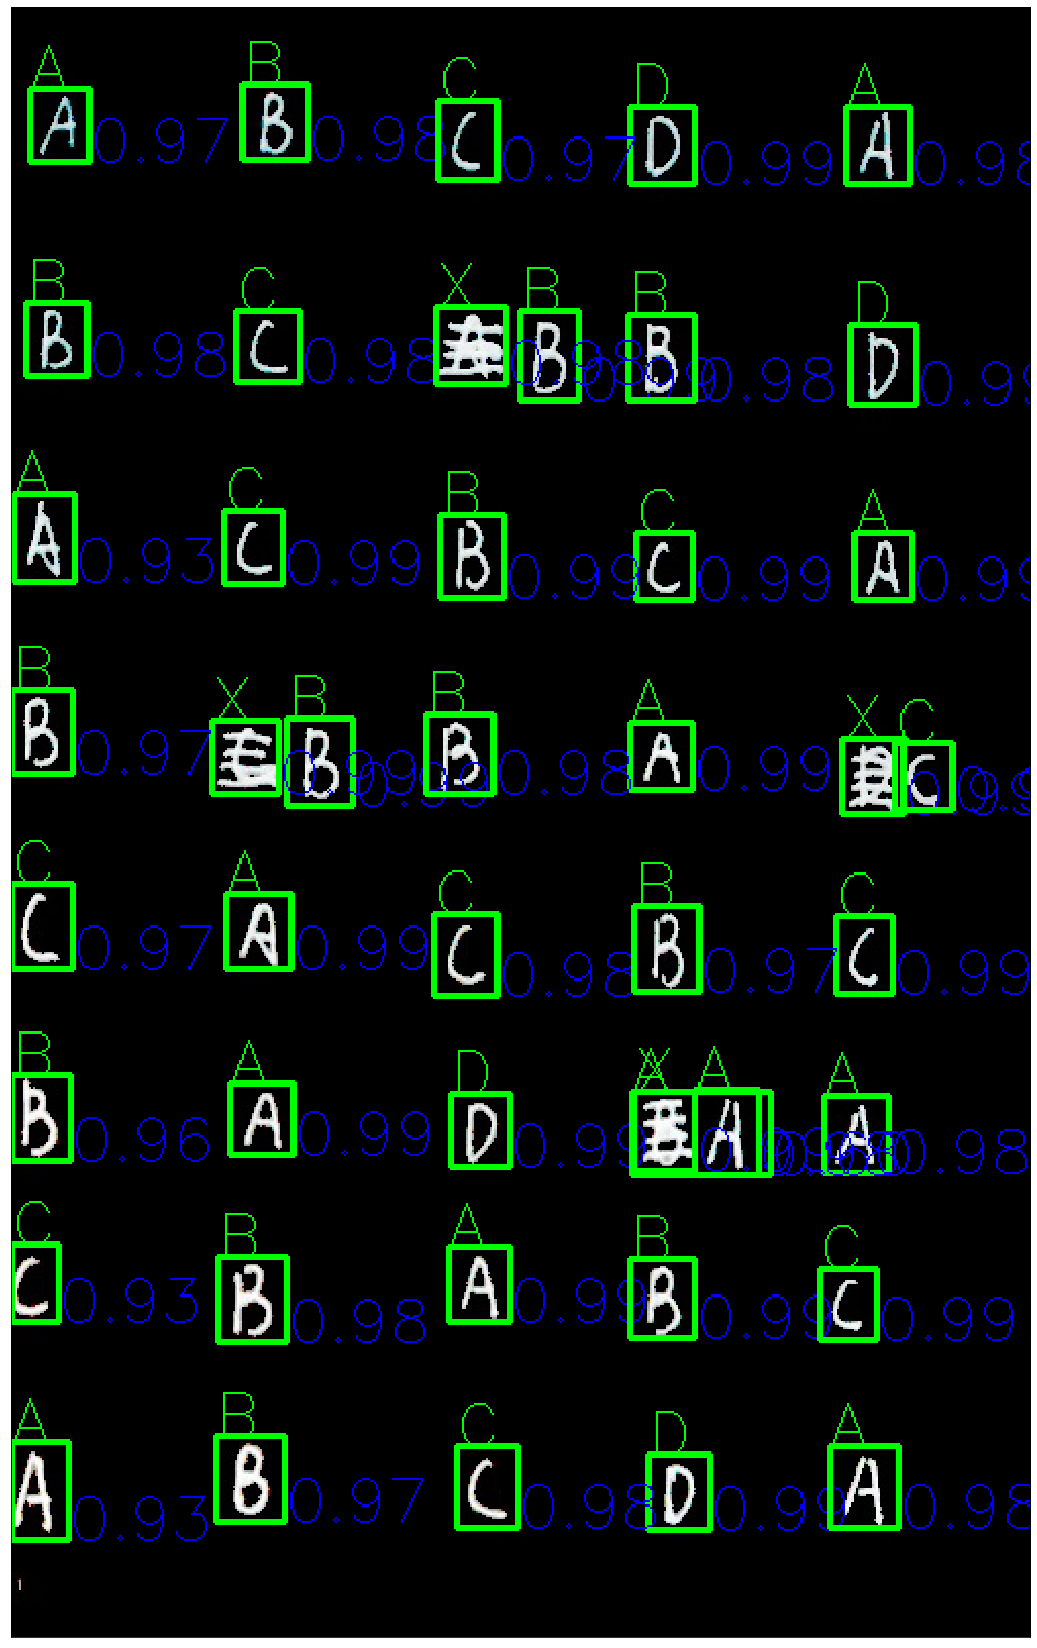

In [8]:
detection('./test_.jpg', threshold=0.6, rect_th=2, text_size=1, text_th=1)